# Analysis Tool

### {notes on how to run go here}

In [9]:
# Import Python Libraries
import numpy as np
import jax      # PIP JAX install - Search for the windows [cpu] version
import jaxlib
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpyro
import numpyro.distributions as dist
from pathlib import Path
import scipy.stats as stats
import shutil

In [2]:
# Figure Parameters Reset to default
def fig_reset():
    style.use('default')  # Clear any custom styles that might have been applied
    plt.close('all')  # Clear any active figures
    plt.set_cmap('viridis')  # Reset default colormaps
    plt.rcParams.update(plt.rcParamsDefault)  # Clear any manually set default figure or axes properties
    plt.ioff()  # Reset interactive mode
    mpl.rcdefaults()  # Reset all rcParams to default values
    mpl.rcParams.update(mpl.rcParamsDefault)  # Additional resets for completeness

fig_reset() # Reset MATPLOTLIB parameters to default

# Colors
color_in = 'red'
color_mid = 'green'
color_out = 'blue'
color_by_num = ['crimson', 'orange', 'goldenrod', 'green', 'skyblue', 'darkorchid']
simple_color = ['red', 'orange', 'yellow', 'green', 'blue', 'orchid']

# Color pallette
α = .5
ß = 0.25
line_width = 1.5
full_line_sty = [':', '--', '-', '-.']
full_marker_pal = ['o','x','^','s','P','H','*']
full_color_pal = ['red', 'orange', 'gold', 'green', 'b', 'darkorchid', 'chocolate', 'deeppink', 'cyan', 'darkcyan', 'black']
full_color_pal_disk = ['dimgrey', 'b', 'limegreen', 'firebrick', 'gold', 'orchid', 'chocolate', 'deeppink', 'cyan', 'darkcyan', 'black']


<Figure size 640x480 with 0 Axes>

#### Growth Rate Settled Test

In [12]:
# Command used inside Growth_Rate_Slope_Test to check if the Star and Disk growth rates are settled and agree with each other globally
def check_slope_agreement(test_slope, threshold, screen_view):  # test_slope: system's growth rates, threshold: max allowed % difference for agreement, screen_view: print values on screen if True
    # Separate Disk and Star slopes
    D_slopes = {k: v for k, v in test_slope.items() if k.startswith("D_")}
    S_slopes = {k: v for k, v in test_slope.items() if k.startswith("S_")}

    # Compute the averages
    avg_D = np.mean(list(D_slopes.values()))        # Disk average
    avg_S = np.mean(list(S_slopes.values()))        # Star average
    avg_Sys = np.mean(list(test_slope.values()))    # System average
    Sys_diff = (abs((avg_D - avg_S) / avg_Sys))     # Difference % between Star & Disk
    if screen_view == True:
        print('\n--- Average Growth Rates ---')
        print(f"Disk: {avg_D:.8f}, Star: {avg_S:.8f}, System: {avg_Sys:.8f}")
    else:
        pass

    # Set initial Star and Disk agreement status
    D_status = False
    S_status = False
    Sys_status = False

    # Function to check agreement within a group
    def check_internal_agreement(group, avg, screen_view):
        for k, v in group.items():
            diff = abs((v - avg) / avg)  # Relative difference
            status = "AGREE" if diff <= threshold else "DISAGREE"
            if screen_view == True:
                print(f"{k}: {v:.8f} | Diff: {diff:.3%} -> {status}")
            else:
                pass

    # Check if all slopes in Disk agree within threshold
    if screen_view == True:
        print("\n--- Disk Growth Rate Agreement Check ---")
    else:
        pass
    check_internal_agreement(group=D_slopes, avg=avg_D, screen_view=screen_view)
    if all(abs((v - avg_D) / avg_D) <= threshold for v in D_slopes.values()):
        D_status = True  # Set to True if all slopes agree
        if screen_view == True:
            print("Disk Settled")
        else:
            pass
    else:
        if screen_view == True:
            print('Disk NOT Settled')
        else:
            pass
        pass
    
    # Check if all slopes in Star agree within threshold
    if screen_view == True:
        print("\n--- Star Growth Rate Agreement Check ---")
    else:
        pass
    check_internal_agreement(group=S_slopes, avg=avg_S, screen_view=screen_view)
    if all(abs((v - avg_S) / avg_S) <= threshold for v in S_slopes.values()):
        S_status = True  # Set to True if all slopes agree
        if screen_view == True:
            print("Star Settled")
        else:
            pass
    else:
        if screen_view == True:
            print('Star NOT Settled')
        else:
            pass
        pass
        
    # Check if System agrees within threshold
    if screen_view == True:
        print("\n--- System Agreement Check ---")
    else:
        pass
    if D_status == True and S_status == True:
        # Compare Disk and Star to check if they agree
        if Sys_diff <= threshold:
            Sys_status = True
            if screen_view == True:
                print(f"System Difference: {Sys_diff:.2%} -> System Settled Check: {Sys_status}")
            else:
                pass
        else:
            if screen_view == True:
                print('System NOT Settled, Star & Disk Settled but do NOT agree')
                print('Model needs further time evolution')
            else:
                pass
            pass
    else:
        if screen_view == True:
            print('System NOT Settled, Star or Disk do not agree')
            print('Model needs further time evolution')
        else:
            pass
        pass
    return(Sys_status)

# Deploys Growth Rate Gobal Agreement test for a single model
def Growth_Rate_Slope_Test(MIRP_rng, threshold, screen_view, target_folder): # Uses linear regression to build a list of slopes for the Star and Disk, MIRP_rng sets the amount of MIRPS to test from the end of the dataset
    # Column titles, Star is from fort.22, Disk is from fort.23
    col_name_1 = ['MIRP', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    col_name_2 = ['MIRP', 'D_gr_inner_amp', 'D_gr_inner_phase', 'D_gr_middle_amp', 'D_gr_middle_phase', 'D_gr_outer_amp', 'D_gr_outer_phase']

    # Clear any previous dataframe info cashed
    df1 = None
    df2 = None
    
    # Load data
    df1 = pd.read_csv(target_folder / "fort.22", names=col_name_1, header=None, sep='\s+')
    df2 = pd.read_csv(target_folder / "fort.23", names=col_name_2, header=None, sep='\s+')

    # Merge the dataframes on the 'MIRP' column
    df = pd.merge(df1, df2, on="MIRP", suffixes=('_disk', '_star'))

    # Drop all columns that end with 'phase'
    df = df.drop(columns=df.filter(regex='phase$').columns)

    # Ensure that MIRP is numeric
    df["MIRP"] = pd.to_numeric(df["MIRP"], errors="coerce")

    # Define the range for regression
    MIRP_range = MIRP_rng
    last_MIRP = df['MIRP'].iloc[-1]
    MIRP_threshold = last_MIRP - MIRP_range

    # Filter the data for the MIRP time range
    df_subset = df[df['MIRP'] >= MIRP_threshold]

    # List of columns to process
    Settle_Test_Columns = ['D_gr_inner_amp', 'D_gr_middle_amp', 'D_gr_outer_amp', 
            'S_gr_inner_amp', 'S_gr_middle_amp', 'S_gr_outer_amp']
    
    # Store slopes for each column
    slopes = {}

    # Loop through each column and perform regression
    for idx, column in enumerate(Settle_Test_Columns):
        # Apply log transformation to the y-axis
        df_subset = df_subset.copy()  # Avoid SettingWithCopyWarning
        df_subset[f'log_{column}'] = np.log10(df_subset[column])

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset['MIRP'], df_subset[f'log_{column}'])
        
        # Store the slope in the dictionary
        slopes[column] = slope

    if screen_view == True:
        print(f'Growth Rates Generated using Linear Regression using final {MIRP_rng} MIRP')
    else:
        pass

    # Test the slopes for agreement (agree=settled)
    model_status = check_slope_agreement(test_slope=slopes, threshold=threshold, screen_view=screen_view)
    return(model_status)

# # Run a test for the Growth_Rate_Slope_Test Global Agreement
# Growth_Rate_Slope_Test(MIRP_rng=2.0, threshold=0.01, screen_view=True)

In [13]:
# Deploy Growth_Rate_Slope_Test for Global Agreement for all Unverified Models
def Deploy_GR_Global_Test(MIRP_rng, threshold): # Set target path for 'Unverified_Models' & 'Settled_Models'
    # Establish directory paths
        # Location of results .xls file
    base_models_path = Path("..", "Data_Galactic_Formation", "Models").resolve()
        # Unverified_Models - target folder for models to be tested if global growth rates have settled into mode
    unverified_models_path = Path("..", "Data_Galactic_Formation", "Models", "Unverified_Models").resolve()
        # Settled_Models - target folder for Globally Settled models verified to be Settled into Global Growth Rate Mode
    settled_models_path = Path("..", "Data_Galactic_Formation", "Models", "Settled_Models").resolve()

    # Ensure target directories exist before the loop starts
        # Creates new directory if none exist. If directory already exists this line skips
    unverified_models_path.mkdir(parents=True, exist_ok=True)
    settled_models_path.mkdir(parents=True, exist_ok=True)

    # Create lists of Unsettled, Settled, or Errored models
    settled_model_list = []
    unsettled_model_list = []
    errored_model_list = []
    
    # Test each model in Unverified_Models folder for Global Growth Rate
        # Moves settled models into Settled_Model folder, leaves unsettled models and adds to a list for HPC restart, errors are compiled into list
    for target_folder in unverified_models_path.iterdir():
        # Verify only directories are targeted
        if not target_folder.is_dir():
            continue  # Skip if not a directory

        # Verify target model contains required files fort.22 & fort.23
        if not (target_folder / "fort.22").exists() or not (target_folder / "fort.23").exists():
            print(f"Warning: {target_folder.name} is missing fort.22 or fort.23")
            errored_model_list.append([target_folder.name, "Error: Missing required files"])  # Append to error list
            continue  # Skip this folder if fort.22 or fort.23 is missing

        # Deploy and Sort models based on Global Growth Rate test results
        print(f"\nTesting Growth Rate: {target_folder.name}")
        GR_model_status = Growth_Rate_Slope_Test(MIRP_rng=MIRP_rng, threshold=threshold, screen_view=True, target_folder=target_folder)
        print(f"{target_folder.name} | Model settled into mode: {GR_model_status}")
        print('Regression completed, Growth Rates established')
        if GR_model_status:
            # Move verified settled models into Settled_Models folder with New/Updated status
            dest_folder = settled_models_path / target_folder.name
            model_status = "Settled: New" if not dest_folder.exists() else "Settled: Updated"
            shutil.move(str(target_folder), str(dest_folder))
            settled_model_list.append([target_folder.name, model_status])  # Append to settled list
            print(f"settled model {target_folder.name} added to list and moved")
        else:
            unsettled_model_list.append([target_folder.name, "Unsettled"])  # Append to unsettled list
            print(f"unsettled model {target_folder.name} added to list")
        
    # Create Results DataFrame and concatenate tested models
    df_settled_model = pd.DataFrame(settled_model_list, columns=["Model", "Status"])
    df_unsettled_model = pd.DataFrame(unsettled_model_list, columns=["Model", "Status"])
    df_errored_model = pd.DataFrame(errored_model_list, columns=["Model", "Status"])
    df_results = pd.concat([df for df in [df_settled_model, df_unsettled_model, df_errored_model] if not df.empty], ignore_index=True)
    
    # Save DataFrame as an .xls file
    results_file = base_models_path / "model_status_results.xls"
    df_results.to_excel(results_file, index=False)


In [14]:
Deploy_GR_Global_Test(MIRP_rng=2.0, threshold=0.01)


Testing Growth Rate: q2.0np0.0js262ks158jin718LogRho-0.506642jout918m3
Growth Rates Generated using Linear Regression using final 2.0 MIRP

--- Average Growth Rates ---
Disk: 2.24196762, Star: 2.24313417, System: 2.24255089

--- Disk Growth Rate Agreement Check ---
D_gr_inner_amp: 2.24196787 | Diff: 0.000% -> AGREE
D_gr_middle_amp: 2.24196756 | Diff: 0.000% -> AGREE
D_gr_outer_amp: 2.24196742 | Diff: 0.000% -> AGREE
Disk Settled

--- Star Growth Rate Agreement Check ---
S_gr_inner_amp: 2.24546827 | Diff: 0.104% -> AGREE
S_gr_middle_amp: 2.24196709 | Diff: 0.052% -> AGREE
S_gr_outer_amp: 2.24196716 | Diff: 0.052% -> AGREE
Star Settled

--- System Agreement Check ---
System Difference: 0.05% -> System Settled Check: True
q2.0np0.0js262ks158jin718LogRho-0.506642jout918m3 | Model settled into mode: True
Regression completed, Growth Rates established
settled model q2.0np0.0js262ks158jin718LogRho-0.506642jout918m3 added to list and moved

Testing Growth Rate: q2.0np0.0js262ks198jin478LogRho

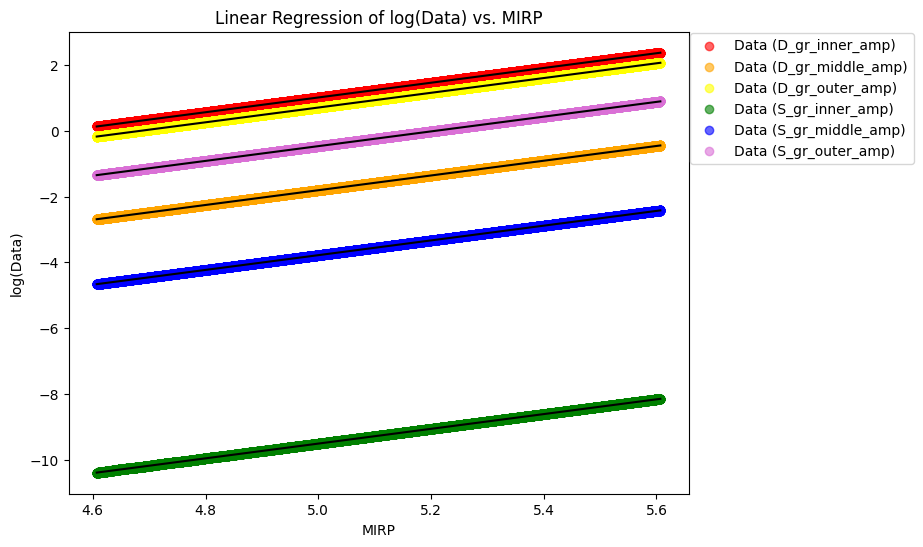

Slope for D_gr_inner_amp (color: red): 2.24196804
Slope for D_gr_middle_amp (color: orange): 2.24196790
Slope for D_gr_outer_amp (color: yellow): 2.24196835
Slope for S_gr_inner_amp (color: green): 2.24227222
Slope for S_gr_middle_amp (color: blue): 2.24196608
Slope for S_gr_outer_amp (color: orchid): 2.24196575


In [5]:
# Load data, Star is from fort.22, Disk is from fort.23
col_name_1 = ['MIRP', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
col_name_2 = ['MIRP', 'D_gr_inner_amp', 'D_gr_inner_phase', 'D_gr_middle_amp', 'D_gr_middle_phase', 'D_gr_outer_amp', 'D_gr_outer_phase']

df1 = pd.read_csv("fort.22", names=col_name_1, header=None, sep='\s+')
df2 = pd.read_csv("fort.23", names=col_name_2, header=None, sep='\s+')

# Merge the dataframes on the 'MIRP' column
df = pd.merge(df1, df2, on="MIRP", suffixes=('_disk', '_star'))

# Drop all columns that end with 'phase'
df = df.drop(columns=df.filter(regex='phase$').columns)

# Ensure that MIRP is numeric
df["MIRP"] = pd.to_numeric(df["MIRP"], errors="coerce")

# Define the range for regression
MIRP_range = 1.0
last_MIRP = df['MIRP'].iloc[-1]
MIRP_threshold = last_MIRP - MIRP_range

# Filter the data for the MIRP time range
df_subset = df[df['MIRP'] >= MIRP_threshold]

# Plotting the data and the regression lines
plt.figure(figsize=(8, 6))

# List of columns to process
columns = ['D_gr_inner_amp', 'D_gr_middle_amp', 'D_gr_outer_amp', 
           'S_gr_inner_amp', 'S_gr_middle_amp', 'S_gr_outer_amp']

# Simple colors to use
colors = simple_color

# Store slopes for each column
slopes = {}

# Loop through each column and perform regression
for idx, column in enumerate(columns):
    # Apply log transformation to the y-axis
    df_subset = df_subset.copy()  # Avoid SettingWithCopyWarning
    df_subset[f'log_{column}'] = np.log10(df_subset[column])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset['MIRP'], df_subset[f'log_{column}'])

    # Store the slope in the dictionary
    slopes[column] = slope
    color = colors[idx]  # Get the color from the list

    # Plot the original data (log-transformed)
    plt.scatter(df_subset['MIRP'], df_subset[f'log_{column}'], label=f'Data ({column})', alpha=0.6, color=color)

    # Plot the regression line
    regression_line = slope * df_subset['MIRP'] + intercept
    plt.plot(df_subset['MIRP'], regression_line, label=None, color='black')

# Adding labels and title
plt.xlabel('MIRP')
plt.ylabel('log(Data)')
plt.title('Linear Regression of log(Data) vs. MIRP')

# Displaying the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.1)

# Show the plot
plt.show()

# Print out the slopes for each column with the color used
for idx, (column, slope) in enumerate(slopes.items()):
    color = colors[idx]  # Get the color used in the plot
    print(f"Slope for {column} (color: {color}): {slope:.8f}")



In [6]:
def MIRP_Settled_Test(MIRP_rng): # Checks if the Star and Disk growth rate have settled into mode
    # Load data, Star is from fort.22, Disk is from fort.23
    col_name_1 = ['MIRP', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    col_name_2 = ['MIRP', 'D_gr_inner_amp', 'D_gr_inner_phase', 'D_gr_middle_amp', 'D_gr_middle_phase', 'D_gr_outer_amp', 'D_gr_outer_phase']

    df1 = pd.read_csv("fort.22", names=col_name_1, header=None, sep='\s+')
    df2 = pd.read_csv("fort.23", names=col_name_2, header=None, sep='\s+')

    # Merge the dataframes on the 'MIRP' column
    df = pd.merge(df1, df2, on="MIRP", suffixes=('_disk', '_star'))

    # Drop all columns that end with 'phase'
    df = df.drop(columns=df.filter(regex='phase$').columns)

    # Ensure that MIRP is numeric
    df["MIRP"] = pd.to_numeric(df["MIRP"], errors="coerce")

    # Define the range for regression
    MIRP_range = MIRP_rng
    last_MIRP = df['MIRP'].iloc[-1]
    MIRP_threshold = last_MIRP - MIRP_range

    # Filter the data for the MIRP time range
    df_subset = df[df['MIRP'] >= MIRP_threshold]

    # List of columns to process
    columns = ['D_gr_inner_amp', 'D_gr_middle_amp', 'D_gr_outer_amp', 
            'S_gr_inner_amp', 'S_gr_middle_amp', 'S_gr_outer_amp']
    
    # Store slopes for each column
    slopes = {}

    # Loop through each column and perform regression
    for idx, column in enumerate(columns):
        # Apply log transformation to the y-axis
        df_subset = df_subset.copy()  # Avoid SettingWithCopyWarning
        df_subset[f'log_{column}'] = np.log10(df_subset[column])

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset['MIRP'], df_subset[f'log_{column}'])
        
        # Store the slope in the dictionary
        slopes[column] = slope

    # Print out the slopes for each column
    for idx, (column, slope) in enumerate(slopes.items()):
        print(f"Slope for {column}: {slope:.8f}")

MIRP_Settled_Test(2.0)

Slope for D_gr_inner_amp: 2.24196787
Slope for D_gr_middle_amp: 2.24196756
Slope for D_gr_outer_amp: 2.24196742
Slope for S_gr_inner_amp: 2.24546827
Slope for S_gr_middle_amp: 2.24196709
Slope for S_gr_outer_amp: 2.24196716
